"""
Bank Marketing Campaign Analysis
==============================

This script performs comprehensive analysis of bank marketing campaign data
using machine learning techniques. It provides insights into customer behavior,
campaign effectiveness, and predictive modeling.

Requirements:
------------
- scikit-learn >= 1.6.0
- xgboost >= 2.1.3
- Additional dependencies listed in requirements.txt

Version Verification:
------------------
The script begins by checking the installed versions of key machine learning
libraries to ensure compatibility.
"""

In [22]:

# Check scikit-learn version
import sklearn
print("scikit-learn version:", sklearn.__version__)

# Check xgboost version
import xgboost
print("xgboost version:", xgboost.__version__)


scikit-learn version: 1.6.0
xgboost version: 2.1.3


In [23]:
# Cell 1: Install required packages
!pip install xgboost plotly

"""
Library Imports and Configuration
-------------------------------
This section imports all required libraries and configures visualization settings.

Imported Libraries:
1. Data Manipulation:
   - pandas (pd): For data processing and analysis
   - numpy (np): For numerical operations

2. Visualization:
   - matplotlib.pyplot (plt): For basic plotting
   - seaborn (sns): For statistical visualizations
   - plotly: For interactive plots

3. Machine Learning:
   - sklearn: For preprocessing, model selection, and evaluation
   - xgboost: For gradient boosting models

Configuration:
- Sets seaborn whitegrid style for consistent plot appearance
- Formats float display to 3 decimal places
- Suppresses warnings for cleaner output
"""

# Cell 2: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Set visualization styles
#plt.style.use('seaborn')
sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [24]:
# Cell 3: Load and check data
def load_and_check_data(file_path):
    """
    Performs comprehensive initial data analysis with enhanced checks.

    This function loads a CSV file and performs several key checks to ensure
    data quality and provide initial insights into the marketing campaign dataset.
    It analyzes four critical aspects of the data:
    - Basic dataset information (shape, memory usage)
    - Data types of columns
    - Missing value detection
    - Target variable distribution

    Parameters:
    -----------
    file_path : str
        Path to the CSV file containing the marketing campaign data.
        The file should include columns for customer attributes and
        campaign outcomes.

    Returns:
    --------
    pd.DataFrame
        The loaded and validated DataFrame containing all marketing
        campaign data, ready for further analysis.

    Notes:
    ------
    - Memory usage is reported in MB for easier interpretation
    - Missing values analysis helps identify data quality issues
    - Target distribution shows class balance/imbalance

    Examples:
    --------
    >>> df = load_and_check_data('marketing_data.csv')
    >>> print(f"Dataset has {df.shape[0]} rows and {df.shape[1]} columns")
    Dataset has 40000 rows and 14 columns
    """


    print("Loading data and performing initial checks...")
    df = pd.read_csv(file_path)

    print("\n=== Basic Dataset Information ===")
    print(f"Dataset Shape: {df.shape}")
    print(f"\nMemory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

    print("\n=== Data Types ===")
    print(df.dtypes)

    print("\n=== Missing Values Check ===")
    missing = df.isnull().sum()
    print(missing[missing > 0] if missing.sum() > 0 else "No missing values found")

    print("\n=== Target Distribution ===")
    target_dist = df['y'].value_counts(normalize=True).round(3) * 100
    print(f"No: {target_dist['no']:.1f}%")
    print(f"Yes: {target_dist['yes']:.1f}%")

    return df

# Cell 4: Function to create balanced binning
def create_balanced_binning(data, column, n_bins=5, include_negative=True):
    """
    Creates balanced bins for numeric data with support for negative values.

    This function implements a balanced binning strategy that's particularly
    useful for features like account balance or campaign duration. It ensures
    each bin (except possibly the negative bin) contains roughly the same
    number of samples, which helps in creating more meaningful analysis.

    Parameters:
    -----------
    data : pd.DataFrame
        Input DataFrame containing the column to be binned
    column : str
        Name of the column to create bins for (e.g., 'balance', 'duration')
    n_bins : int, default=5
        Number of bins to create for positive values. Choose based on
        data distribution and analysis needs.
    include_negative : bool, default=True
        Whether to create a separate bin for negative values. Useful
        for features like account balance.

    Returns:
    --------
    tuple (np.array, list)
        bin_edges: Array of bin boundaries for use with pd.cut()
        labels: List of human-readable bin labels (e.g., "0 to 100")

    Notes:
    ------
    - Creates balanced bins based on percentiles for positive values
    - Optionally handles negative values in a separate bin
    - Generates human readable labels for the bins

    Examples:
    --------
    >>> bins, labels = create_balanced_binning(df, 'balance', n_bins=4)
    >>> df['balance_category'] = pd.cut(df['balance'], bins=bins, labels=labels)
    >>> print(df['balance_category'].value_counts())
    Negative          500
    0 to 1000        625
    1000 to 2000     625
    2000 to 5000     625
    5000 and above   625
    """


    if include_negative:
        negative_mask = data[column] < 0
        positive_data = data[~negative_mask][column]
    else:
        positive_data = data[column]

    quantiles = np.linspace(0, 100, n_bins+1)
    bin_edges = np.percentile(positive_data, quantiles)

    labels = []
    if include_negative:
        bin_edges = np.insert(bin_edges, 0, data[column].min())
        labels.append(f"Negative")

    for i in range(len(bin_edges)-1):
        labels.append(f"{bin_edges[i]:.0f} to {bin_edges[i+1]:.0f}")

    return bin_edges, labels

# Cell 5: Load your data

df = load_and_check_data('/content/term-deposit-marketing-2020 (2).csv')  # Replace with the filename

# Display first few rows
print("\nFirst few rows of the dataset:")
display(df.head())

Loading data and performing initial checks...

=== Basic Dataset Information ===
Dataset Shape: (40000, 14)

Memory Usage: 22.78 MB

=== Data Types ===
age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
y            object
dtype: object

=== Missing Values Check ===
No missing values found

=== Target Distribution ===
No: 92.8%
Yes: 7.2%

First few rows of the dataset:


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no



Balance Analysis Metrics:


y                    
                 success_rate count success_count
balance_category                                 
Less than -1000         2.797   143             4
-1000 to 0              5.473  6797           372
0 to 200                5.907  7889           466
200 to 500              6.897  6902           476
500 to 1000             7.612  6056           461
1000 to 2000            8.375  5218           437
More than 2000          9.721  6995           680


Balance Distribution Insights:
Total number of customers with negative balance: 3731
Total number of customers with positive balance: 36269

Median balance: 407.00
95th percentile balance: 5517.00


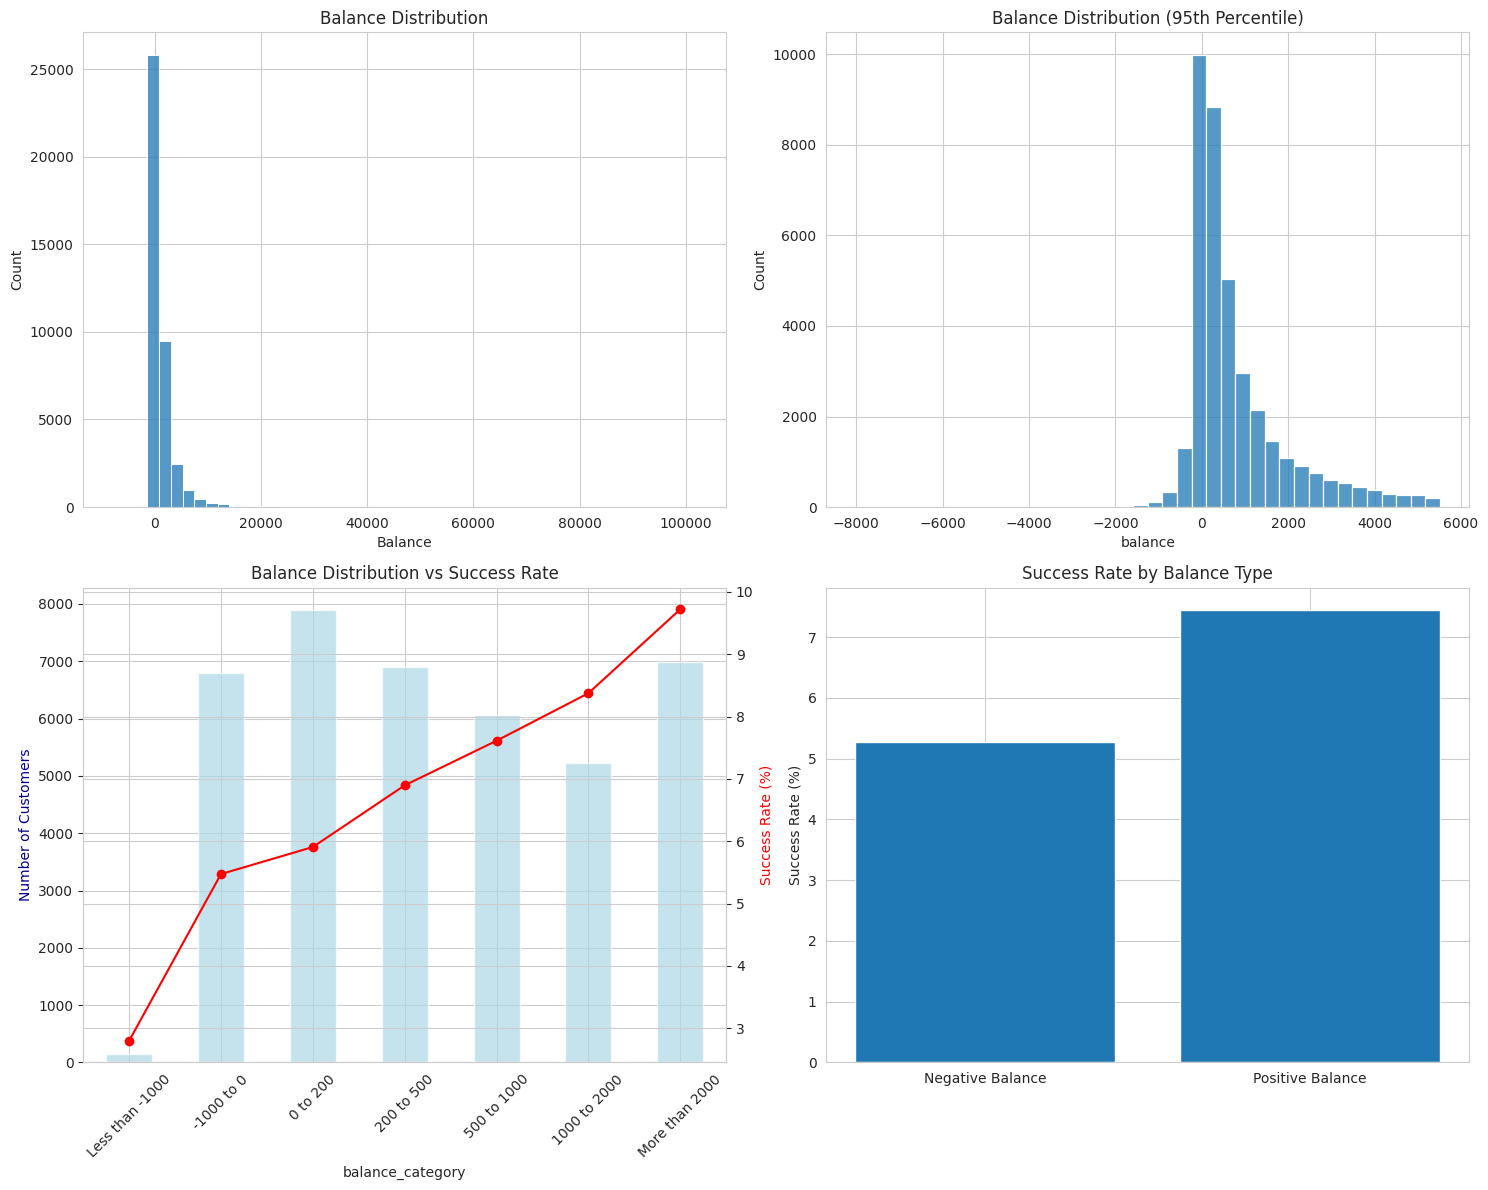

In [14]:
# Cell 6: Balance Distribution Analysis
def analyze_balance_distribution(df):
    """
    Performs comprehensive analysis of account balance distribution and its impact on success rate.

    This function analyzes how customer account balances relate to campaign success rates
    through four complementary analyses:

    1. Overall Balance Distribution
       Shows the complete distribution of account balances across all customers,
       helping identify common balance ranges and potential outliers.

    2. Core Range Analysis
       Focuses on the central 95% of balances by removing extreme outliers,
       providing a clearer view of typical customer balances.

    3. Success Rate by Balance Category
       Analyzes how campaign success varies across different balance ranges:
       - Less than -1000
       - -1000 to 0
       - 0 to 200
       - 200 to 500
       - 500 to 1000
       - 1000 to 2000
       - More than 2000

    4. Positive vs Negative Balance Comparison
       Compares success rates between customers with positive and negative balances
       to identify any significant patterns.

    Parameters:
    -----------
    df : pd.DataFrame
        Input DataFrame containing customer data with columns:
        - balance: Customer account balance
        - y: Campaign outcome ('yes'/'no')

    Returns:
    --------
    pd.DataFrame
        Balance analysis metrics including:
        - success_rate: Percentage of successful conversions in each balance category
        - count: Number of customers in each category
        - success_count: Number of successful conversions
        - ci_lower: Lower bound of 95% confidence interval
        - ci_upper: Upper bound of 95% confidence interval

    Notes:
    ------
    Confidence Intervals Explanation:
    - Each success rate comes with a 95% confidence interval
    - Interpretation example:
      If success_rate = 15% with CI [13% - 17%], we can be 95% confident
      that the true success rate lies between 13% and 17%
    - Wider intervals (e.g., [10% - 20%]) indicate less certainty
    - Narrower intervals (e.g., [14% - 16%]) indicate more reliable estimates

    Visualization Details:
    - Uses subplots to show all analyses in one figure
    - Combines bar charts (for counts) with line plots (for rates)
    - Color coding: blue for counts, red for success rates

    Example:
    --------
    >>> metrics = analyze_balance_distribution(df)
    >>> best_category = metrics['y']['success_rate'].idxmax()
    >>> print(f"Best performing balance category: {best_category}")
    >>> print(f"Success rate: {metrics['y']['success_rate'][best_category]:.1f}%")
    """


    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Overall Distribution
    sns.histplot(data=df, x='balance', bins=50, ax=axes[0,0])
    axes[0,0].set_title('Balance Distribution')
    axes[0,0].set_xlabel('Balance')
    axes[0,0].set_ylabel('Count')

    # 2. Focus on Core Range (excluding outliers)
    q95 = df['balance'].quantile(0.95)
    common_range = df[df['balance'] <= q95]
    sns.histplot(data=common_range, x='balance', bins=40, ax=axes[0,1])
    axes[0,1].set_title('Balance Distribution (95th Percentile)')

    # 3. Success Rate Analysis
    # Create balance bins manually as per mentor's suggestion
    balance_bins = [-np.inf, -1000, 0, 200, 500, 1000, 2000, np.inf]
    balance_labels = [
        'Less than -1000',
        '-1000 to 0',
        '0 to 200',
        '200 to 500',
        '500 to 1000',
        '1000 to 2000',
        'More than 2000'
    ]

    df['balance_category'] = pd.cut(df['balance'],
                                  bins=balance_bins,
                                  labels=balance_labels)

    # Calculate metrics with confidence intervals
    balance_metrics = df.groupby('balance_category').agg({
        'y': [
            ('success_rate', lambda x: (x == 'yes').mean() * 100),
            ('count', 'size'),
            ('success_count', lambda x: (x == 'yes').sum())
        ]
    })

    # Plot dual axis chart
    ax2 = axes[1,0].twinx()

    # Bars for count
    balance_metrics['y']['count'].plot(kind='bar', ax=axes[1,0],
                                     color='lightblue', alpha=0.7)
    axes[1,0].set_ylabel('Number of Customers', color='darkblue')

    # Line for success rate
    balance_metrics['y']['success_rate'].plot(kind='line', marker='o',
                                            ax=ax2, color='red')
    ax2.set_ylabel('Success Rate (%)', color='red')
    axes[1,0].set_title('Balance Distribution vs Success Rate')

    # Rotate x-labels
    axes[1,0].tick_params(axis='x', rotation=45)

    # 4. Analyze negative balances
    neg_balance = df[df['balance'] < 0]
    pos_balance = df[df['balance'] >= 0]

    neg_rate = (neg_balance['y'] == 'yes').mean() * 100
    pos_rate = (pos_balance['y'] == 'yes').mean() * 100

    axes[1,1].bar(['Negative Balance', 'Positive Balance'],
                 [neg_rate, pos_rate])
    axes[1,1].set_title('Success Rate by Balance Type')
    axes[1,1].set_ylabel('Success Rate (%)')

    plt.tight_layout()

    # Calculate confidence intervals for metrics
    z = 1.96  # 95% confidence level
    balance_metrics['y']['ci_lower'] = balance_metrics['y'].apply(
        lambda x: x['success_rate'] - z * np.sqrt(
            (x['success_rate'] * (100 - x['success_rate'])) / x['count']
        ), axis=1
    )
    balance_metrics['y']['ci_upper'] = balance_metrics['y'].apply(
        lambda x: x['success_rate'] + z * np.sqrt(
            (x['success_rate'] * (100 - x['success_rate'])) / x['count']
        ), axis=1
    )

    return balance_metrics

# Cell 7: Run balance analysis
balance_metrics = analyze_balance_distribution(df)
print("\nBalance Analysis Metrics:")
display(balance_metrics)

# Print additional insights
print("\nBalance Distribution Insights:")
print(f"Total number of customers with negative balance: {len(df[df['balance'] < 0])}")
print(f"Total number of customers with positive balance: {len(df[df['balance'] >= 0])}")
print(f"\nMedian balance: {df['balance'].median():.2f}")
print(f"95th percentile balance: {df['balance'].quantile(0.95):.2f}")


Campaign Insights:
Median number of contacts: 2.0
Average call duration: 4.2 minutes

Success Rate by Contact Attempts:
                success_rate  count
campaign_group                     
0-2                    7.823  25871
3-5                    6.751   9909
6-10                   5.242   3033
More than 10           3.707   1187

Campaign Analysis Metrics:


y                                       
               success_rate  count success_count ci_lower ci_upper
campaign_group                                                    
0-2                   7.823  25871          2024    7.496    8.151
3-5                   6.751   9909           669    6.257    7.245
6-10                  5.242   3033           159    4.449    6.036
More than 10          3.707   1187            44    2.632    4.782


Duration Analysis Metrics:


y                                       
               success_rate  count success_count ci_lower ci_upper
duration_group                                                    
0-2                   0.802  12964           104    0.649    0.956
2-5                   2.951  16467           486    2.693    3.210
5-10                 10.741   7206           774   10.026   11.456
10-15                37.572   2076           780   35.489   39.656
15-30                59.056   1187           701   56.259   61.854
30+                  52.577     97            51   42.640   62.514

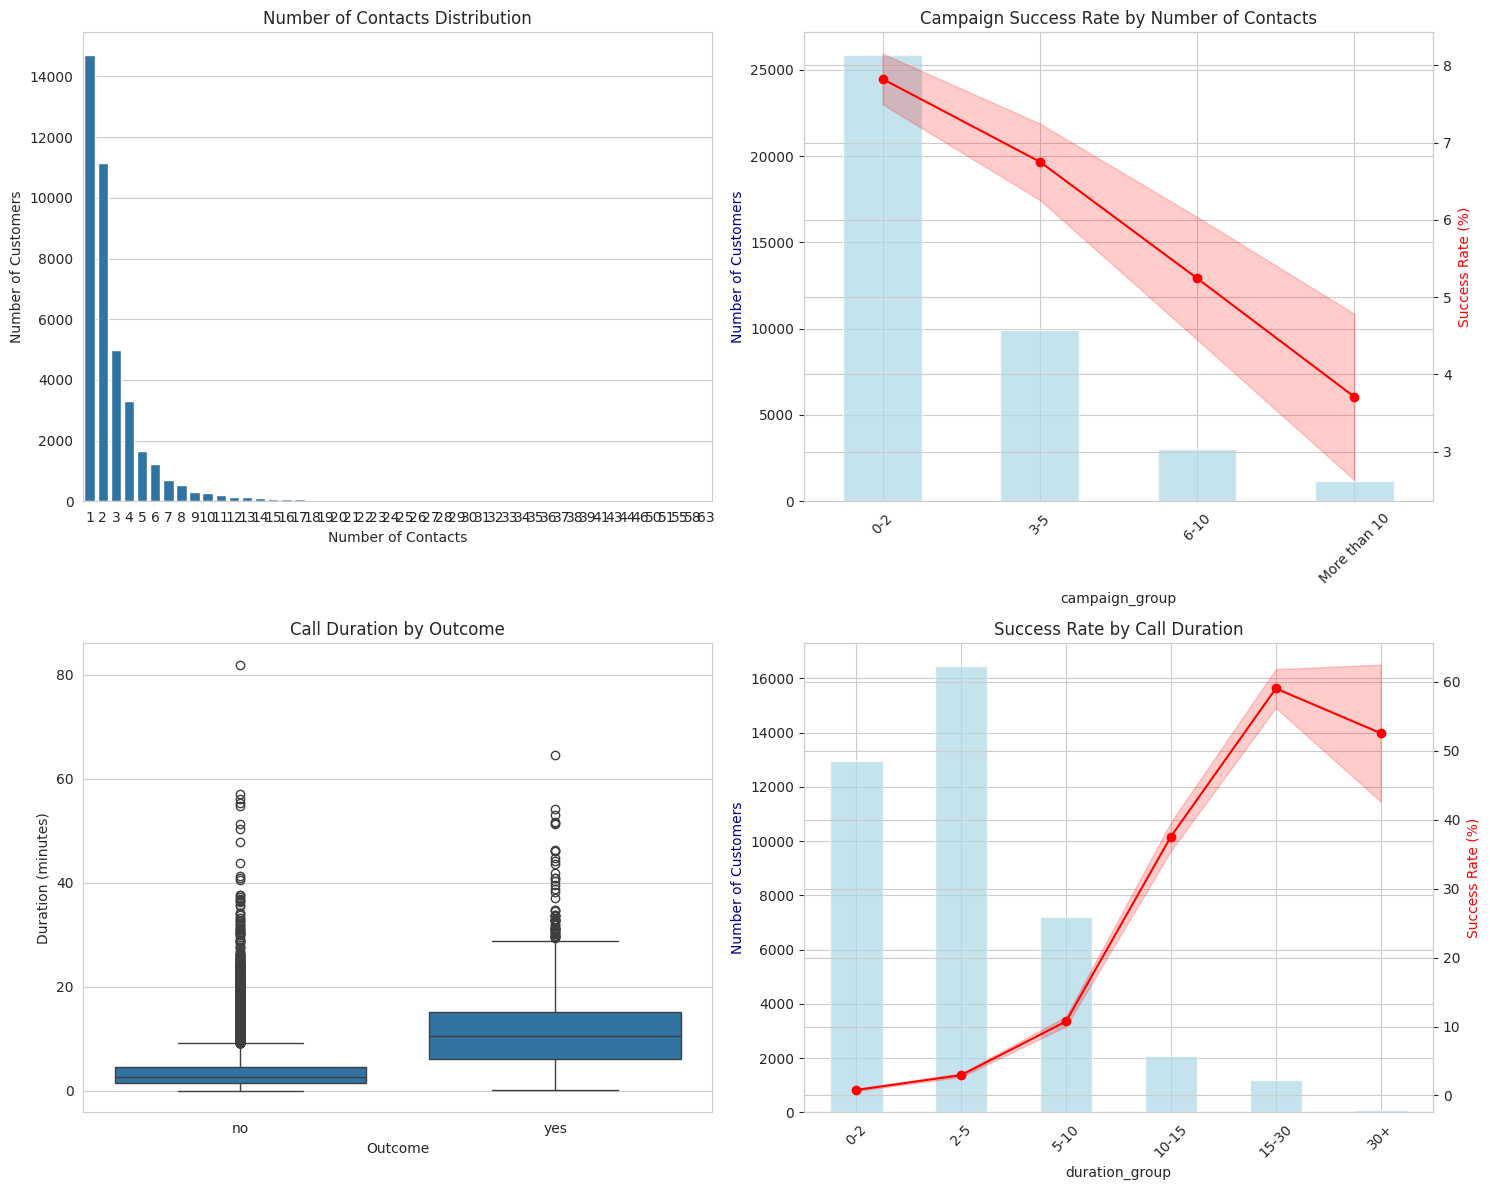

In [15]:
# Cell 8: Campaign Effectiveness Analysis
def analyze_campaign_effectiveness(df):
    """
    Analyzes campaign patterns with validation of counterintuitive trends.

    Creates visualizations and analyses for:
    1. Campaign contact distribution
    2. Campaign success rate analysis with confidence intervals
    3. Call duration analysis
    4. Duration success rate analysis

    Parameters:
    -----------
    df : pd.DataFrame
        Input DataFrame containing campaign data

    Returns:
    --------
    tuple (pd.DataFrame, pd.DataFrame)
        - campaign_metrics: Campaign effectiveness metrics
        - duration_metrics: Duration analysis metrics
        Both include success rates, counts, and confidence intervals

    Notes:
    ------
    - Confidence intervals (ci_lower, ci_upper) show the statistical uncertainty
      in success rates using a 95% confidence level
    - Duration is analyzed in minutes for easier interpretation
    - Success rates are normalized to percentages
    """

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Campaign Distribution
    campaign_dist = df['campaign'].value_counts().sort_index()
    sns.barplot(x=campaign_dist.index, y=campaign_dist.values, ax=axes[0,0])
    axes[0,0].set_title('Number of Contacts Distribution')
    axes[0,0].set_xlabel('Number of Contacts')
    axes[0,0].set_ylabel('Number of Customers')

    # 2. Campaign Success Analysis with validation

    campaign_bins = [0, 2, 5, 10, float('inf')]
    campaign_labels = ['0-2', '3-5', '6-10', 'More than 10']
    df['campaign_group'] = pd.cut(df['campaign'],
                                bins=campaign_bins,
                                labels=campaign_labels)

    # Calculate base metrics
    campaign_metrics = df.groupby('campaign_group').agg({
        'y': [
            ('success_rate', lambda x: (x == 'yes').mean() * 100),
            ('count', 'size'),
            ('success_count', lambda x: (x == 'yes').sum())
        ]
    }).copy()  # Create a copy to avoid SettingWithCopyWarning

    # Calculate confidence intervals
    z = 1.96  # 95% confidence level
    for idx in campaign_metrics.index:
        success_rate = campaign_metrics.loc[idx, ('y', 'success_rate')]
        count = campaign_metrics.loc[idx, ('y', 'count')]

        ci = z * np.sqrt((success_rate * (100 - success_rate)) / count)
        campaign_metrics.loc[idx, ('y', 'ci_lower')] = success_rate - ci
        campaign_metrics.loc[idx, ('y', 'ci_upper')] = success_rate + ci

    # Create dual-axis plot
    ax2 = axes[0,1].twinx()

    # Bars for count
    campaign_metrics['y']['count'].plot(kind='bar', ax=axes[0,1],
                                      color='lightblue', alpha=0.7)
    axes[0,1].set_ylabel('Number of Customers', color='darkblue')

    # Line for success rate with confidence intervals
    x = range(len(campaign_metrics.index))
    ax2.plot(x, campaign_metrics['y']['success_rate'], 'r-o')
    ax2.fill_between(x,
                    campaign_metrics['y']['ci_lower'],
                    campaign_metrics['y']['ci_upper'],
                    color='red', alpha=0.2)
    ax2.set_ylabel('Success Rate (%)', color='red')

    axes[0,1].set_title('Campaign Success Rate by Number of Contacts')
    axes[0,1].tick_params(axis='x', rotation=45)

    # 3. Duration Analysis
    df['duration_minutes'] = df['duration'] / 60
    sns.boxplot(data=df, x='y', y='duration_minutes', ax=axes[1,0])
    axes[1,0].set_title('Call Duration by Outcome')
    axes[1,0].set_xlabel('Outcome')
    axes[1,0].set_ylabel('Duration (minutes)')

    # 4. Duration Success Rate Analysis
    duration_bins = [0, 2, 5, 10, 15, 30, df['duration_minutes'].max()]
    duration_labels = ['0-2', '2-5', '5-10', '10-15', '15-30', '30+']
    df['duration_group'] = pd.cut(df['duration_minutes'],
                                bins=duration_bins,
                                labels=duration_labels)

    duration_metrics = df.groupby('duration_group').agg({
        'y': [
            ('success_rate', lambda x: (x == 'yes').mean() * 100),
            ('count', 'size'),
            ('success_count', lambda x: (x == 'yes').sum())
        ]
    }).copy()

    # Calculate confidence intervals for duration metrics
    for idx in duration_metrics.index:
        success_rate = duration_metrics.loc[idx, ('y', 'success_rate')]
        count = duration_metrics.loc[idx, ('y', 'count')]

        ci = z * np.sqrt((success_rate * (100 - success_rate)) / count)
        duration_metrics.loc[idx, ('y', 'ci_lower')] = success_rate - ci
        duration_metrics.loc[idx, ('y', 'ci_upper')] = success_rate + ci

    ax3 = axes[1,1].twinx()

    # Bars for count
    duration_metrics['y']['count'].plot(kind='bar', ax=axes[1,1],
                                      color='lightblue', alpha=0.7)
    axes[1,1].set_ylabel('Number of Customers', color='darkblue')

    # Line for success rate with confidence intervals
    x = range(len(duration_metrics.index))
    ax3.plot(x, duration_metrics['y']['success_rate'], 'r-o')
    ax3.fill_between(x,
                    duration_metrics['y']['ci_lower'],
                    duration_metrics['y']['ci_upper'],
                    color='red', alpha=0.2)
    ax3.set_ylabel('Success Rate (%)', color='red')

    axes[1,1].set_title('Success Rate by Call Duration')
    axes[1,1].tick_params(axis='x', rotation=45)

    plt.tight_layout()

    # Print additional insights
    print("\nCampaign Insights:")
    print(f"Median number of contacts: {df['campaign'].median():.1f}")
    print(f"Average call duration: {df['duration_minutes'].mean():.1f} minutes")
    print("\nSuccess Rate by Contact Attempts:")
    print(campaign_metrics['y'][['success_rate', 'count']].to_string())

    return campaign_metrics, duration_metrics

# Cell 9: Run campaign analysis
campaign_metrics, duration_metrics = analyze_campaign_effectiveness(df)

print("\nCampaign Analysis Metrics:")
display(campaign_metrics)
print("\nDuration Analysis Metrics:")
display(duration_metrics)


Analyzing Job Categories...

Insights for Success Rate by Job Category:
non_working:
  Success Rate: 10.7% (95% CI: 9.6% - 11.8%)
  Sample Size: 3065
other:
  Success Rate: 7.2% (95% CI: 3.9% - 10.5%)
  Sample Size: 235
professional:
  Success Rate: 8.0% (95% CI: 7.5% - 8.5%)
  Sample Size: 10985
service_admin:
  Success Rate: 6.8% (95% CI: 6.3% - 7.3%)
  Sample Size: 9480
technical:
  Success Rate: 6.4% (95% CI: 6.0% - 6.7%)
  Sample Size: 16235

Job Category Analysis Results:


y                                       
              success_rate  count success_count ci_lower ci_upper
job_category                                                     
non_working         10.734   3065           329    9.638   11.830
other                7.234    235            17    3.922   10.546
professional         7.975  10985           876    7.468    8.481
service_admin        6.772   9480           642    6.266    7.278
technical            6.357  16235          1032    5.981    6.732


Analyzing Age Groups...

Insights for Success Rate by Age Group:
18-25:
  Success Rate: 13.6% (95% CI: 11.4% - 15.8%)
  Sample Size: 939
26-35:
  Success Rate: 8.1% (95% CI: 7.7% - 8.6%)
  Sample Size: 13856
36-45:
  Success Rate: 6.3% (95% CI: 5.9% - 6.8%)
  Sample Size: 12856
46-55:
  Success Rate: 6.0% (95% CI: 5.5% - 6.5%)
  Sample Size: 8792
56-65:
  Success Rate: 7.3% (95% CI: 6.5% - 8.2%)
  Sample Size: 3429
65+:
  Success Rate: 42.2% (95% CI: 33.6% - 50.7%)
  Sample Size: 128

Age Group Analysis Results:


y                                       
          success_rate  count success_count ci_lower ci_upper
age_group                                                    
18-25           13.632    939           128   11.437   15.826
26-35            8.105  13856          1123    7.650    8.559
36-45            6.339  12856           815    5.918    6.761
46-55            5.960   8792           524    5.465    6.455
56-65            7.349   3429           252    6.476    8.222
65+             42.188    128            54   33.632   50.743


Overall Demographics Summary:
Total number of customers: 40000

Job Category Distribution:
job_category
technical       40.600
professional    27.500
service_admin   23.700
non_working      7.700
other            0.600

Age Group Distribution:
age_group
26-35   34.600
36-45   32.100
46-55   22.000
56-65    8.600
18-25    2.300
65+      0.300


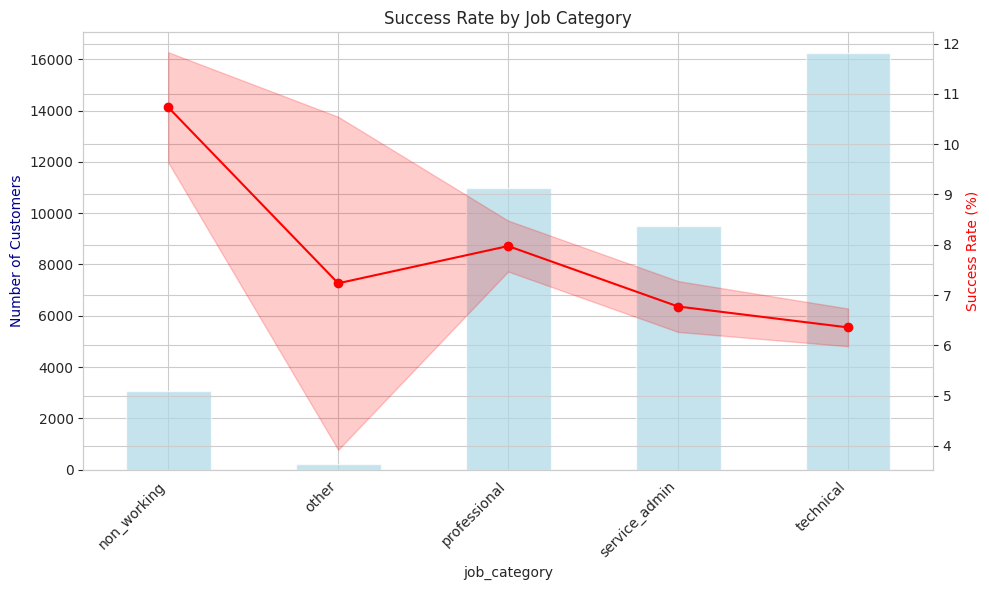

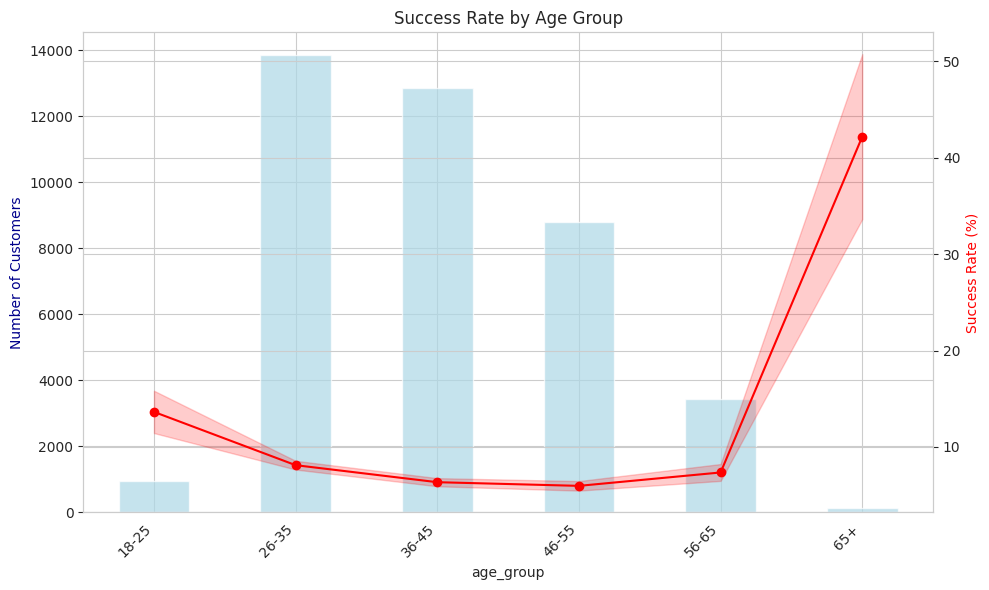

In [16]:
# Cell 10: Demographic Analysis Functions
def create_job_categories(df):
    """
    Creates standardized job categories for marketing campaign analysis.

    This function maps various job titles into five main categories to simplify
    analysis and identify patterns in customer segments. The categorization
    is based on business domain expertise and common career groupings.

    Parameters:
    -----------
    df : pd.DataFrame
        Input DataFrame containing a 'job' column with original job titles

    Returns:
    --------
    pd.Series
        A series containing mapped job categories for each customer

    Categories:
    -----------
    - non_working: Students, retirees, and unemployed individuals
    - professional: Management and entrepreneurial positions
    - technical: Technical and skilled labor positions
    - service_admin: Service and administrative roles
    - other: Unknown or uncategorized positions

    Examples:
    --------
    >>> df['job_category'] = create_job_categories(df)
    >>> print(df[['job', 'job_category']].head())
    job          job_category
    student      non_working
    manager      professional
    technician   technical

    Notes:
    ------
    The categorization helps identify which professional segments
    are more likely to respond positively to the campaign.
    """


    job_mapping = {
        'student': 'non_working',
        'retired': 'non_working',
        'unemployed': 'non_working',
        'management': 'professional',
        'self-employed': 'professional',
        'entrepreneur': 'professional',
        'technician': 'technical',
        'blue-collar': 'technical',
        'services': 'service_admin',
        'admin': 'service_admin',
        'housemaid': 'service_admin',
        'unknown': 'other'
    }

    return df['job'].map(job_mapping)

def analyze_categorical_success(df, column, title):
    """
    Analyzes campaign success rates across different customer categories.

    Creates a comprehensive analysis combining statistical metrics and
    visualizations to understand how different customer segments respond
    to the marketing campaign.

    Parameters:
    -----------
    df : pd.DataFrame
        Marketing campaign data containing:
        - Categorical column to analyze
        - 'y' column with campaign outcomes ('yes'/'no')
    column : str
        Name of the categorical column to analyze (e.g., 'job_category')
    title : str
        Title for the analysis plots and output

    Returns:
    --------
    pd.DataFrame
        Multi-level DataFrame containing for each category:
        - success_rate: Percentage of successful conversions
        - count: Number of customers
        - success_count: Number of successful conversions
        - ci_lower: Lower bound of 95% confidence interval
        - ci_upper: Upper bound of 95% confidence interval

    Visualization:
    -------------
    Creates a dual-axis plot showing:
    1. Bar chart: Customer count by category (left axis)
    2. Line plot: Success rate with confidence intervals (right axis)

    Statistical Details:
    ------------------
    - Uses 95% confidence intervals (z=1.96)
    - Confidence intervals show uncertainty in success rates
    - Wider intervals indicate less reliable estimates
    - Narrower intervals suggest more reliable patterns

    Examples:
    --------
    >>> age_metrics = analyze_categorical_success(
    ...     df, 'age_group', 'Success Rate by Age Group')
    >>> print(f"Best performing age group: "
    ...       f"{age_metrics['y']['success_rate'].idxmax()}")
    """

    fig, ax = plt.subplots(figsize=(10, 6))

    # Calculate base metrics
    metrics = df.groupby(column).agg({
        'y': [
            ('success_rate', lambda x: (x == 'yes').mean() * 100),
            ('count', 'size'),
            ('success_count', lambda x: (x == 'yes').sum())
        ]
    }).copy()

    # Calculate confidence intervals
    z = 1.96
    for idx in metrics.index:
        success_rate = metrics.loc[idx, ('y', 'success_rate')]
        count = metrics.loc[idx, ('y', 'count')]

        ci = z * np.sqrt((success_rate * (100 - success_rate)) / count)
        metrics.loc[idx, ('y', 'ci_lower')] = success_rate - ci
        metrics.loc[idx, ('y', 'ci_upper')] = success_rate + ci

    # Create dual-axis plot
    ax2 = ax.twinx()

    # Bars for count
    metrics['y']['count'].plot(kind='bar', ax=ax, color='lightblue', alpha=0.7)
    ax.set_ylabel('Number of Customers', color='darkblue')

    # Line for success rate with confidence intervals
    x = range(len(metrics.index))
    ax2.plot(x, metrics['y']['success_rate'], 'r-o')
    ax2.fill_between(x,
                    metrics['y']['ci_lower'],
                    metrics['y']['ci_upper'],
                    color='red', alpha=0.2)
    ax2.set_ylabel('Success Rate (%)', color='red')

    # Set the title and format the plot
    plt.title(title)
    ax.set_xticklabels(metrics.index, rotation=45, ha='right')
    plt.tight_layout()

    # Print insights
    print(f"\nInsights for {title}:")
    for category in metrics.index:
        success_rate = metrics.loc[category, ('y', 'success_rate')]
        count = metrics.loc[category, ('y', 'count')]
        ci_lower = metrics.loc[category, ('y', 'ci_lower')]
        ci_upper = metrics.loc[category, ('y', 'ci_upper')]
        print(f"{category}:")
        print(f"  Success Rate: {success_rate:.1f}% (95% CI: {ci_lower:.1f}% - {ci_upper:.1f}%)")
        print(f"  Sample Size: {count}")

    return metrics

# Cell 11: Run demographic analysis
# Create job categories
df['job_category'] = create_job_categories(df)

# Analyze job categories
print("\nAnalyzing Job Categories...")
job_metrics = analyze_categorical_success(df, 'job_category', 'Success Rate by Job Category')
print("\nJob Category Analysis Results:")
display(job_metrics)

# Create and analyze age groups
print("\nAnalyzing Age Groups...")
age_bins = [0, 25, 35, 45, 55, 65, 100]
age_labels = ['18-25', '26-35', '36-45', '46-55', '56-65', '65+']
df['age_group'] = pd.cut(df['age'], bins=age_bins, labels=age_labels)
age_metrics = analyze_categorical_success(df, 'age_group', 'Success Rate by Age Group')
print("\nAge Group Analysis Results:")
display(age_metrics)

# Additional demographic insights
print("\nOverall Demographics Summary:")
print(f"Total number of customers: {len(df)}")
print("\nJob Category Distribution:")
print(df['job_category'].value_counts(normalize=True).mul(100).round(1).to_string(name=False))
print("\nAge Group Distribution:")
print(df['age_group'].value_counts(normalize=True).mul(100).round(1).to_string(name=False))

In [18]:
# Cell 12: Feature Engineering and Preparation
def prepare_features(df):
    """
    Comprehensive feature engineering implementing mentor's feedback
    """
    feature_df = df.copy()

    # 1. Create numeric categories
    # Balance categories
    balance_bins = [-np.inf, -1000, 0, 200, 500, 1000, 2000, np.inf]
    feature_df['balance_category'] = pd.cut(feature_df['balance'], bins=balance_bins)

    # Duration categories (in minutes)
    feature_df['duration_minutes'] = feature_df['duration'] / 60
    duration_bins = [0, 2, 5, 10, 15, 30, float('inf')]
    feature_df['duration_category'] = pd.cut(feature_df['duration_minutes'], bins=duration_bins)

    # Campaign categories
    campaign_bins = [0, 2, 5, 10, float('inf')]
    feature_df['campaign_category'] = pd.cut(feature_df['campaign'], bins=campaign_bins)

    # Age groups
    age_bins = [0, 25, 35, 45, 55, 65, 100]
    feature_df['age_group'] = pd.cut(feature_df['age'], bins=age_bins)

    # 2. Create job categories as suggested by mentor
    job_mapping = {
        'student': 'non_working',
        'retired': 'non_working',
        'unemployed': 'non_working',
        'management': 'professional',
        'self-employed': 'professional',
        'entrepreneur': 'professional',
        'technician': 'technical',
        'blue-collar': 'technical',
        'services': 'service_admin',
        'admin': 'service_admin',
        'housemaid': 'service_admin',
        'unknown': 'other'
    }
    feature_df['job_category'] = feature_df['job'].map(job_mapping)

    # 3. Select features for model
    categorical_columns = ['job_category', 'marital', 'education', 'default',
                         'housing', 'loan', 'contact', 'balance_category',
                         'duration_category', 'campaign_category', 'age_group']

    # Remove month feature as suggested by mentor
    numeric_features = ['age', 'duration_minutes', 'campaign', 'day']

    # 4. Create dummy variables
    X_categorical = pd.get_dummies(feature_df[categorical_columns])

    # 5. Scale numeric features
    scaler = StandardScaler()
    X_numeric = pd.DataFrame(
        scaler.fit_transform(feature_df[numeric_features]),
        columns=numeric_features,
        index=feature_df.index
    )

    # Combine features
    X = pd.concat([X_categorical, X_numeric], axis=1)

    # Create target variable
    y = (feature_df['y'] == 'yes').astype(int)

    return X, y, scaler

# Cell 13: Prepare features
print("Preparing features...")
X, y, scaler = prepare_features(df)

print("\nFeature matrix shape:", X.shape)
print("\nFeature names:")
print(X.columns.tolist())

Preparing features...

Feature matrix shape: (40000, 48)

Feature names:
['job_category_non_working', 'job_category_other', 'job_category_professional', 'job_category_service_admin', 'job_category_technical', 'marital_divorced', 'marital_married', 'marital_single', 'education_primary', 'education_secondary', 'education_tertiary', 'education_unknown', 'default_no', 'default_yes', 'housing_no', 'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular', 'contact_telephone', 'contact_unknown', 'balance_category_(-inf, -1000.0]', 'balance_category_(-1000.0, 0.0]', 'balance_category_(0.0, 200.0]', 'balance_category_(200.0, 500.0]', 'balance_category_(500.0, 1000.0]', 'balance_category_(1000.0, 2000.0]', 'balance_category_(2000.0, inf]', 'duration_category_(0.0, 2.0]', 'duration_category_(2.0, 5.0]', 'duration_category_(5.0, 10.0]', 'duration_category_(10.0, 15.0]', 'duration_category_(15.0, 30.0]', 'duration_category_(30.0, inf]', 'campaign_category_(0.0, 2.0]', 'campaign_category_(2.0, 5.0]'


Calibrated Model Performance:
ROC-AUC: 0.921

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      7421
           1       0.59      0.37      0.46       579

    accuracy                           0.94      8000
   macro avg       0.77      0.67      0.71      8000
weighted avg       0.93      0.94      0.93      8000



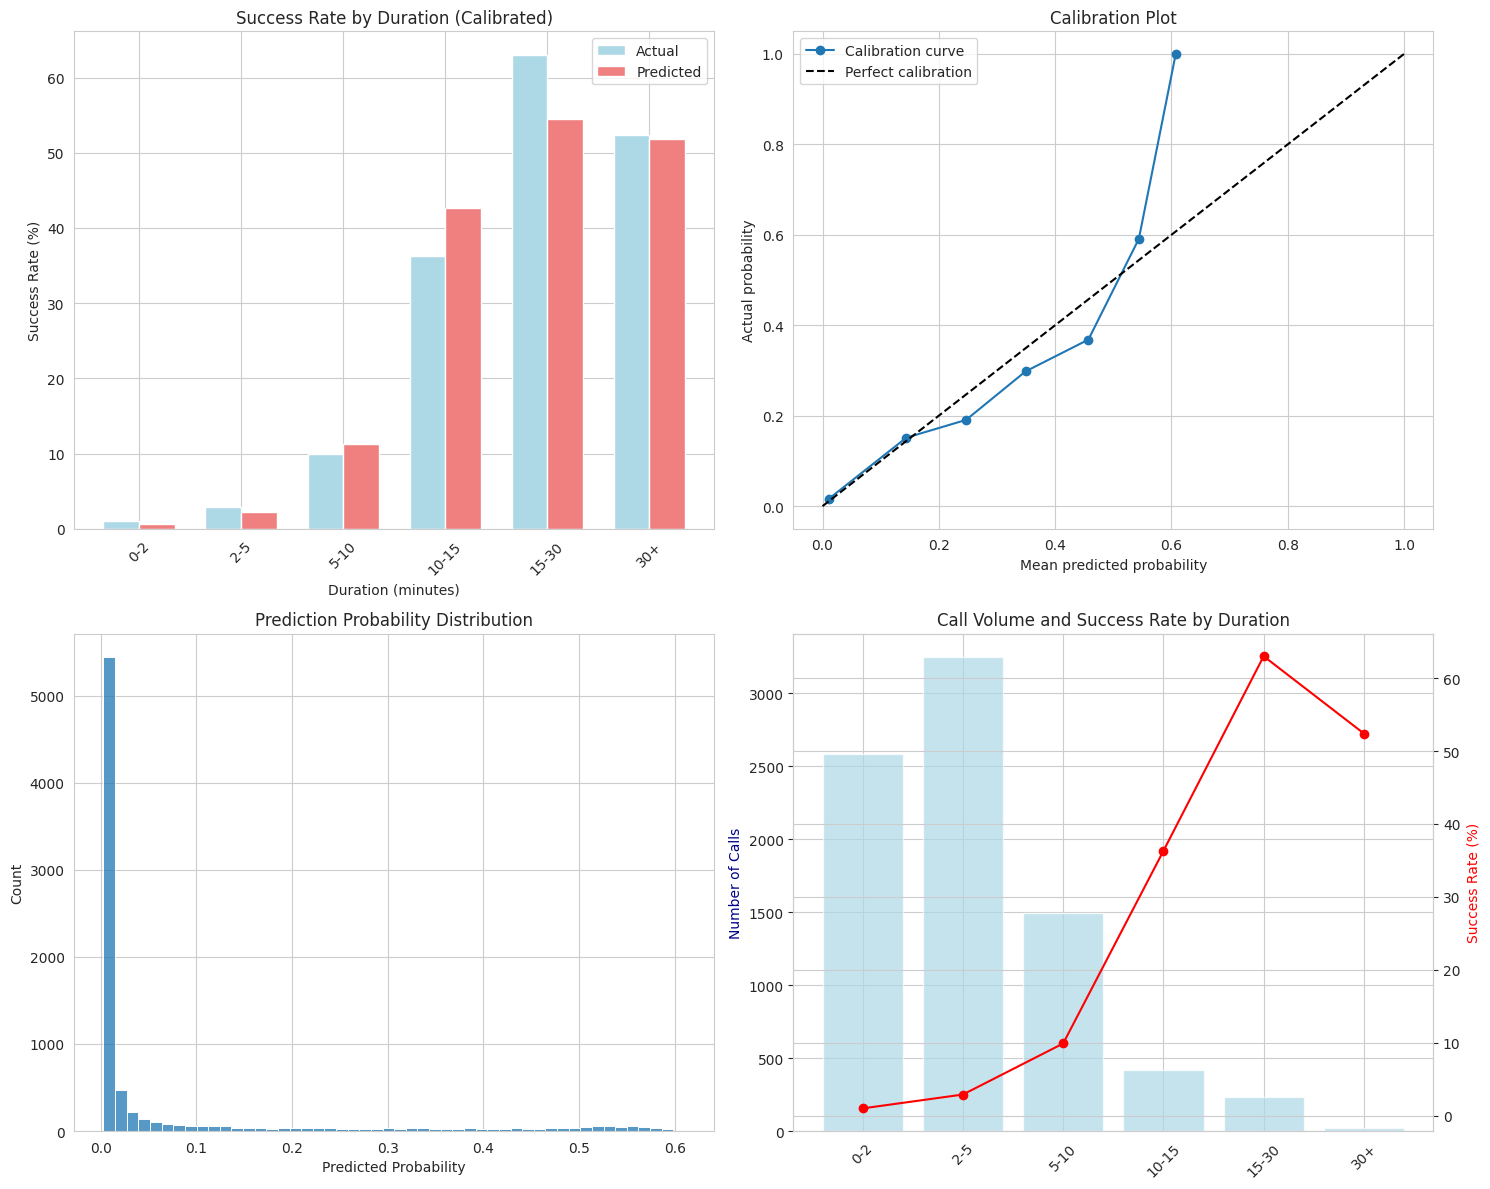


Detailed Duration Analysis:
               actual       predicted_prob
                 mean count           mean
duration_group                            
0-2             1.000  2582          0.600
2-5             2.900  3247          2.200
5-10            9.900  1495         11.300
10-15          36.300   419         42.600
15-30          63.000   235         54.500
30+            52.400    21         51.800
Training original model...
Cross-validation results:
Fold 1 ROC-AUC: 0.917
Fold 2 ROC-AUC: 0.916
Fold 3 ROC-AUC: 0.918
Fold 4 ROC-AUC: 0.914
Fold 5 ROC-AUC: 0.917

Mean CV ROC-AUC: 0.916 (±0.003)

Test Set Performance:
ROC-AUC: 0.919

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.86      0.92      7421
           1       0.32      0.83      0.47       579

    accuracy                           0.86      8000
   macro avg       0.65      0.85      0.69      8000
weighted avg       0.94      0.86      0.89      8000


,feature,importance,category,cumulative_importance
20,contact_unknown,0.156,Other,0.156
45,duration_minutes,0.149,Duration,0.304
14,housing_no,0.059,Other,0.364
16,loan_no,0.051,Other,0.415
27,"balance_category_(2000.0, inf_",0.030,Balance,0.445
38,"age_group_(0, 25_",0.028,Age,0.474
46,campaign,0.028,Campaign,0.501
47,day,0.027,Other,0.528
10,education_tertiary,0.025,Education,0.553
34,"campaign_category_(0.0, 2.0_",0.024,Campaign,0.577



Feature Importance by Category:


,importance
category,
Other,0.326
Duration,0.201
Age,0.112
Balance,0.104
Campaign,0.087
Education,0.063
Job,0.062
Marital,0.045


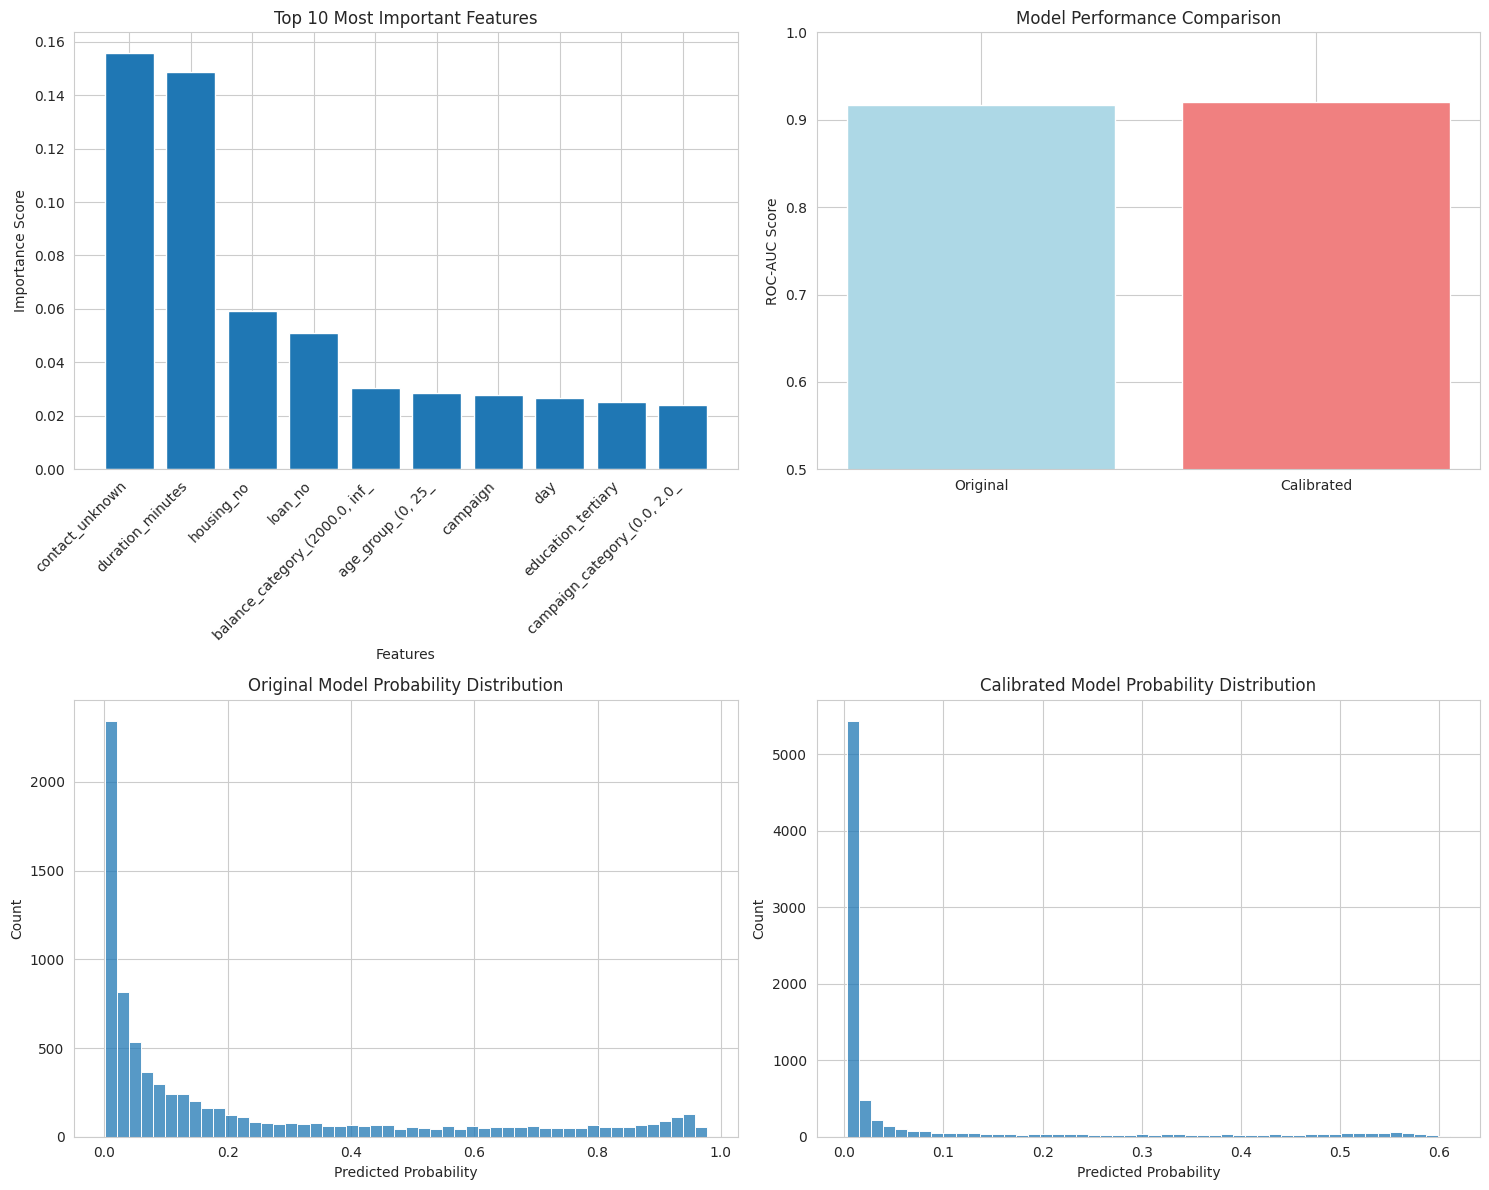


Model Performance Summary:
Original Model Average CV Score: 0.916
Original Model Stability (CV StdDev): 0.001
Calibrated Model ROC-AUC: 0.921


In [21]:
# Cell 14: Model Training and Validation
def train_and_evaluate_model(X, y):
    """
    Trains and validates an XGBoost model with comprehensive evaluation.

    This function:
    1. Prepares data with proper feature name cleaning
    2. Implements stratified cross-validation
    3. Trains a final model with optimized parameters
    4. Provides detailed evaluation metrics and visualizations

    Parameters:
    -----------
    X : pd.DataFrame
        Feature matrix with processed features
    y : pd.Series
        Binary target variable (0/1)

    Returns:
    --------
    dict
        Complete model evaluation results including:
        - model: Trained XGBoost classifier
        - cv_scores: Cross-validation scores
        - feature_importance: Feature importance analysis
        - test predictions and probabilities
    """
    # Clean feature names to remove special characters
    X = X.copy()
    X.columns = [col.replace('[', '_').replace(']', '_').replace('<', 'lt').replace('>', 'gt')
                 for col in X.columns]

    # Create train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        random_state=42,
        stratify=y
    )

    # Initialize model with class balance adjustment
    model = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc',
        scale_pos_weight=len(y[y==0]) / len(y[y==1]),
        max_depth=6,
        learning_rate=0.1,
        n_estimators=100,
        random_state=42,
        use_label_encoder=False  # Add this to avoid warning
    )

    # Perform cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = []

    print("Cross-validation results:")
    for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train), 1):
        # Split data
        X_fold_train = X_train.iloc[train_idx]
        y_fold_train = y_train.iloc[train_idx]
        X_fold_val = X_train.iloc[val_idx]
        y_fold_val = y_train.iloc[val_idx]

        # Train and evaluate
        model.fit(X_fold_train, y_fold_train,
                 eval_set=[(X_fold_val, y_fold_val)],
                 verbose=False)

        # Get predictions
        y_pred_proba = model.predict_proba(X_fold_val)[:, 1]
        fold_score = roc_auc_score(y_fold_val, y_pred_proba)
        cv_scores.append(fold_score)

        print(f"Fold {fold} ROC-AUC: {fold_score:.3f}")

    print(f"\nMean CV ROC-AUC: {np.mean(cv_scores):.3f} (±{np.std(cv_scores)*2:.3f})")

    # Train final model
    model.fit(X_train, y_train)

    # Evaluate on test set
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)[:, 1]

    print("\nTest Set Performance:")
    print(f"ROC-AUC: {roc_auc_score(y_test, y_test_proba):.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_test_pred))

    # Create feature importance DataFrame with cleaned names
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    # Add original feature names for reference
    feature_importance['original_feature'] = X.columns

    # Calculate cumulative importance
    feature_importance['cumulative_importance'] = feature_importance['importance'].cumsum()

    # Add feature category
    def get_feature_category(feature_name):
        if 'job' in feature_name:
            return 'Job'
        elif 'age' in feature_name:
            return 'Age'
        elif 'balance' in feature_name:
            return 'Balance'
        elif 'duration' in feature_name:
            return 'Duration'
        elif 'campaign' in feature_name:
            return 'Campaign'
        elif 'education' in feature_name:
            return 'Education'
        elif 'marital' in feature_name:
            return 'Marital'
        else:
            return 'Other'

    feature_importance['category'] = feature_importance['feature'].apply(get_feature_category)

    return {
        'model': model,
        'cv_scores': cv_scores,
        'feature_importance': feature_importance,
        'test_predictions': y_test_pred,
        'test_probabilities': y_test_proba,
        'test_indices': X_test.index,
        'y_test': y_test,
        'X_test': X_test  # Added for future analysis
    }



# Cell 14a: Clean feature names and train calibrated model
def train_and_evaluate_calibrated_model(X, y):
    """
    Trains and validates a calibrated XGBoost model for improved probability estimates.

    This function implements a two-stage approach:
    1. Base model training with XGBoost
    2. Probability calibration using Platt Scaling

    The calibration process helps ensure that predicted probabilities
    match actual observed frequencies, which is crucial for business
    decision-making.

    Parameters:
    -----------
    X : pd.DataFrame
        Processed feature matrix
    y : pd.Series
        Binary target variable (0/1)

    Returns:
    --------
    dict
        Model evaluation results including:
        - base_model: Trained XGBoost classifier
        - calibrator: Fitted calibration model
        - test_predictions: Calibrated predictions
        - test_probabilities: Calibrated probabilities

    Notes:
    ------
    - Calibration is especially important when probability values
      are used for decision-making
    - The model uses reduced complexity to prevent overfitting
    """

    from sklearn.metrics import classification_report, roc_auc_score
    import xgboost as xgb
    from sklearn.linear_model import LogisticRegression

    # Clean feature names
    X = X.copy()
    X.columns = [col.replace('[', '_').replace(']', '_').replace('<', 'lt').replace('>', 'gt')
                 .replace('(', '_').replace(')', '_').replace(',', '_')
                 for col in X.columns]

    # Create train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        random_state=42,
        stratify=y
    )

    # Initialize and train base model
    base_model = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc',
        scale_pos_weight=len(y[y==0]) / len(y[y==1]),
        max_depth=4,
        learning_rate=0.05,
        n_estimators=200,
        min_child_weight=2, # Helps prevent overfitting
        subsample=0.8,      # Random sampling of training data
        colsample_bytree=0.8,  # Random sampling of features
        random_state=42,
        use_label_encoder=False
    )

    # Train base model
    base_model.fit(X_train, y_train)

    # Get initial predictions
    train_probs = base_model.predict_proba(X_train)[:, 1]
    test_probs = base_model.predict_proba(X_test)[:, 1]

    # Train calibration model (Platt Scaling)
    calibrator = LogisticRegression(random_state=42)
    calibrator.fit(train_probs.reshape(-1, 1), y_train)

    # Get calibrated predictions
    y_pred_proba = calibrator.predict_proba(test_probs.reshape(-1, 1))[:, 1]
    y_pred = (y_pred_proba > 0.5).astype(int)

    # Calculate metrics
    results = {
        'model': base_model,
        'calibrator': calibrator,
        'y_test': y_test,
        'test_predictions': y_pred,
        'test_probabilities': y_pred_proba,
        'test_indices': X_test.index,
        'X_test': X_test
    }

    # Print performance metrics
    print("\nCalibrated Model Performance:")
    print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    return results

def analyze_calibrated_predictions(model_results, df):
    """
    Analyze predictions with focus on duration-based success rates
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.calibration import calibration_curve

    # Create duration categories
    df_test = df.loc[model_results['test_indices']].copy()
    df_test['duration_minutes'] = df_test['duration'] / 60
    duration_bins = [0, 2, 5, 10, 15, 30, float('inf')]
    duration_labels = ['0-2', '2-5', '5-10', '10-15', '15-30', '30+']
    df_test['duration_group'] = pd.cut(df_test['duration_minutes'],
                                     bins=duration_bins,
                                     labels=duration_labels)

    # Add predictions
    df_test['actual'] = (df_test['y'] == 'yes').astype(int)
    df_test['predicted_prob'] = model_results['test_probabilities']
    df_test['predicted'] = model_results['test_predictions']

    # Create visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Success rates by duration
    metrics = df_test.groupby('duration_group').agg({
        'actual': ['mean', 'count'],
        'predicted_prob': 'mean'
    }).round(3)

    metrics[('actual', 'mean')] *= 100
    metrics[('predicted_prob', 'mean')] *= 100

    x = np.arange(len(duration_labels))
    width = 0.35

    ax1.bar(x - width/2, metrics[('actual', 'mean')],
            width, label='Actual', color='lightblue')
    ax1.bar(x + width/2, metrics[('predicted_prob', 'mean')],
            width, label='Predicted', color='lightcoral')

    ax1.set_title('Success Rate by Duration (Calibrated)')
    ax1.set_xlabel('Duration (minutes)')
    ax1.set_ylabel('Success Rate (%)')
    ax1.set_xticks(x)
    ax1.set_xticklabels(duration_labels, rotation=45)
    ax1.legend()

    # 2. Calibration curve
    prob_true, prob_pred = calibration_curve(
        df_test['actual'],
        df_test['predicted_prob'],
        n_bins=10
    )

    ax2.plot(prob_pred, prob_true, marker='o', label='Calibration curve')
    ax2.plot([0, 1], [0, 1], 'k--', label='Perfect calibration')
    ax2.set_title('Calibration Plot')
    ax2.set_xlabel('Mean predicted probability')
    ax2.set_ylabel('Actual probability')
    ax2.legend()

    # 3. Probability distribution
    sns.histplot(data=df_test['predicted_prob'], bins=50, ax=ax3)
    ax3.set_title('Prediction Probability Distribution')
    ax3.set_xlabel('Predicted Probability')
    ax3.set_ylabel('Count')

    # 4. Count by duration with success rate
    ax4_2 = ax4.twinx()

    bars = ax4.bar(x, metrics[('actual', 'count')], color='lightblue', alpha=0.7)
    ax4.set_ylabel('Number of Calls', color='darkblue')

    line = ax4_2.plot(x, metrics[('actual', 'mean')], 'r-o', label='Success Rate')
    ax4_2.set_ylabel('Success Rate (%)', color='red')

    ax4.set_title('Call Volume and Success Rate by Duration')
    ax4.set_xticks(x)
    ax4.set_xticklabels(duration_labels, rotation=45)

    plt.tight_layout()
    plt.show()

    # Print detailed metrics
    print("\nDetailed Duration Analysis:")
    print(metrics)

    return metrics

# Example usage:
calibrated_results = train_and_evaluate_calibrated_model(X, y)
calibrated_metrics = analyze_calibrated_predictions(calibrated_results, df)




# Cell 15: Train and evaluate models

# Original model training and evaluation
print("Training original model...")
model_results = train_and_evaluate_model(X, y)

# Calibrated model training and evaluation
print("\nTraining calibrated model...")
calibrated_results = train_and_evaluate_calibrated_model(X, y)

# Display feature importance analysis from original model
print("\nFeature Importance Analysis:")
print("\nTop 15 Most Important Features:")
display(model_results['feature_importance'][['feature', 'importance', 'category', 'cumulative_importance']].head(15))

# Feature importance by category
category_importance = model_results['feature_importance'].groupby('category')['importance'].sum().sort_values(ascending=False)
print("\nFeature Importance by Category:")
display(category_importance)

# Create comparison plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Feature importance
ax1.bar(range(10), model_results['feature_importance'].head(10)['importance'])
ax1.set_xticks(range(10))
ax1.set_xticklabels(model_results['feature_importance'].head(10)['feature'], rotation=45, ha='right')
ax1.set_title('Top 10 Most Important Features')
ax1.set_xlabel('Features')
ax1.set_ylabel('Importance Score')

# Plot 2: Model comparison
orig_score = np.mean(model_results['cv_scores'])
cal_score = roc_auc_score(calibrated_results['y_test'], calibrated_results['test_probabilities'])
ax2.bar(['Original', 'Calibrated'], [orig_score, cal_score], color=['lightblue', 'lightcoral'])
ax2.set_title('Model Performance Comparison')
ax2.set_ylabel('ROC-AUC Score')
ax2.set_ylim(0.5, 1.0)

# Plot 3: Original model probabilities
sns.histplot(model_results['test_probabilities'], bins=50, ax=ax3)
ax3.set_title('Original Model Probability Distribution')
ax3.set_xlabel('Predicted Probability')

# Plot 4: Calibrated model probabilities
sns.histplot(calibrated_results['test_probabilities'], bins=50, ax=ax4)
ax4.set_title('Calibrated Model Probability Distribution')
ax4.set_xlabel('Predicted Probability')

plt.tight_layout()
plt.show()

# Print performance summary
print("\nModel Performance Summary:")
print(f"Original Model Average CV Score: {np.mean(model_results['cv_scores']):.3f}")
print(f"Original Model Stability (CV StdDev): {np.std(model_results['cv_scores']):.3f}")
print(f"Calibrated Model ROC-AUC: {cal_score:.3f}")

Running Model Validations...

Calibration Metrics:


actual            
             mean count   std
prob_bin                     
(0.0, 0.1]  0.004  4397 0.064
(0.1, 0.2]  0.019  1003 0.136
(0.2, 0.3]  0.035   461 0.183
(0.3, 0.4]  0.053   356 0.225
(0.4, 0.5]  0.091   298 0.288
(0.5, 0.6]  0.129   249 0.335
(0.6, 0.7]  0.161   285 0.369
(0.7, 0.8]  0.298   265 0.458
(0.8, 0.9]  0.362   304 0.481
(0.9, 1.0]  0.558   382 0.497


Running Duration Analysis...

Detailed Duration Analysis:
       actual_mean  predicted_mean    count  ci_lower  ci_upper
0-2          0.968           3.882 2582.000     0.591     1.346
2-5          2.926          14.911 3247.000     2.346     3.505
5-10         9.900          40.824 1495.000     8.386    11.414
10-15       36.277          81.884  419.000    31.673    40.881
15-30       62.979          92.900  235.000    56.805    69.152
30+         52.381          87.442   21.000    31.020    73.742

Generating Recommendations...

Enhanced Recommendations:

Targeting:
- Focus on job_category: technical (Represents 35.6% of high-probability cases)
- Focus on education: secondary (Represents 45.6% of high-probability cases)
- Focus on age_group: 26-35 (Represents 40.4% of high-probability cases)

Contact:
- Optimal call duration: 15-30
- Expected success rate: 63.0% (95% CI: 56.8% - 69.2%)
- Average successful call duration: 11.4 minutes
- Consider duration targets by customer segment


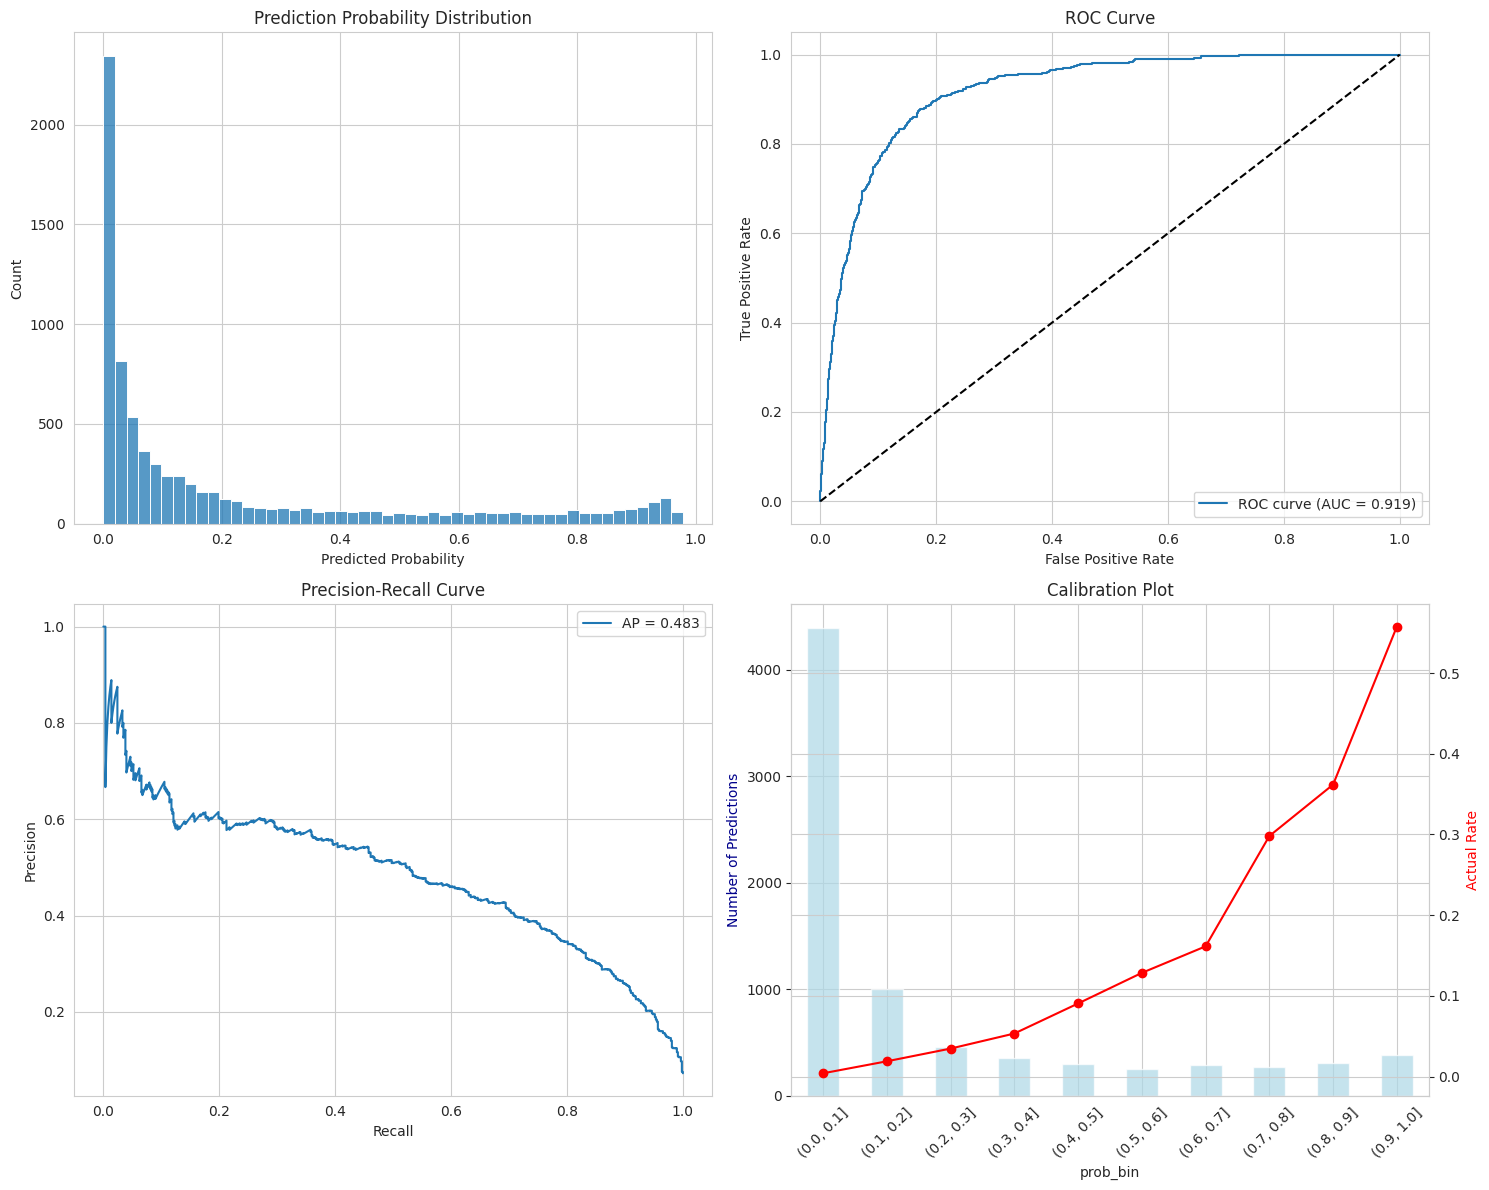

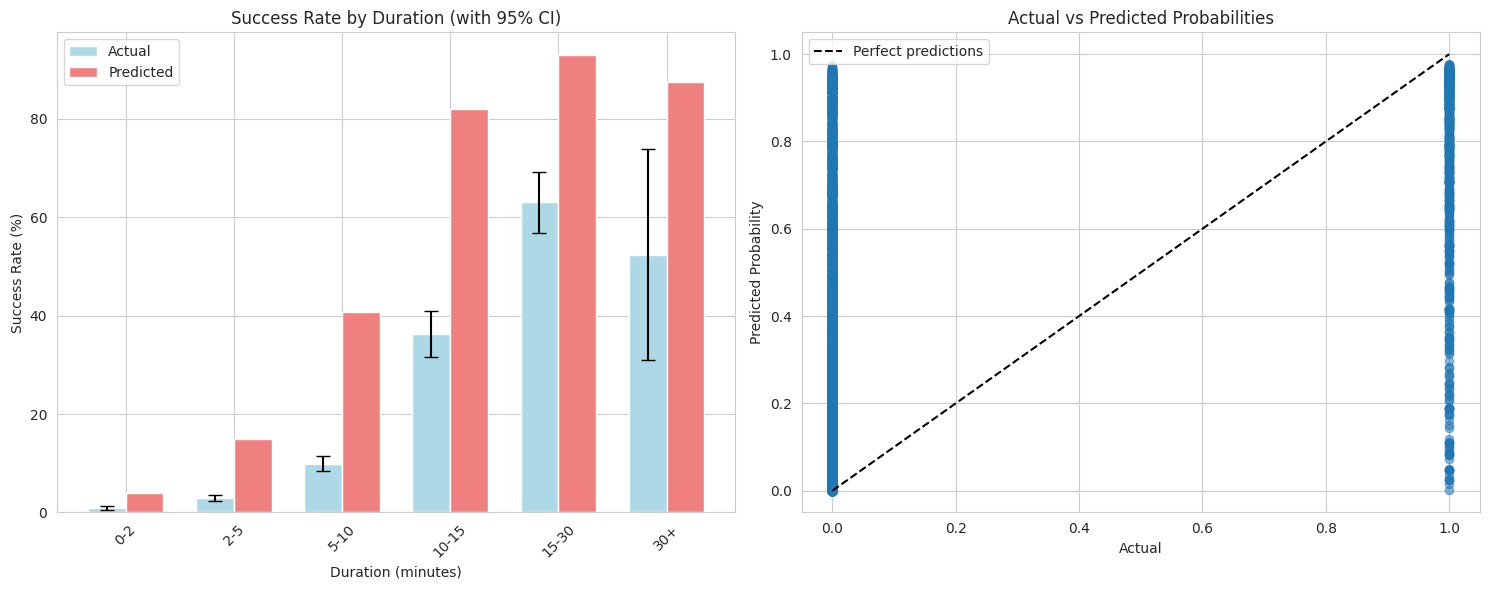

In [20]:
# Cell 16: Model Validation Visualizations
def validate_predictions(model_results, df):
    """
    Create comprehensive validation visualizations
    """
    y_test = model_results['y_test']
    probabilities = model_results['test_probabilities']
    predictions = model_results['test_predictions']

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Probability Distribution (Upper Left)
    sns.histplot(data=probabilities, bins=50, ax=axes[0,0])
    axes[0,0].set_title('Prediction Probability Distribution')
    axes[0,0].set_xlabel('Predicted Probability')
    axes[0,0].set_ylabel('Count')

    # 2. ROC Curve (Upper Right)
    from sklearn.metrics import roc_curve, auc
    fpr, tpr, _ = roc_curve(y_test, probabilities)
    roc_auc = auc(fpr, tpr)
    axes[0,1].plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
    axes[0,1].plot([0, 1], [0, 1], 'k--')
    axes[0,1].set_title('ROC Curve')
    axes[0,1].set_xlabel('False Positive Rate')
    axes[0,1].set_ylabel('True Positive Rate')
    axes[0,1].legend(loc='lower right')

    # 3. Precision-Recall Curve (Lower Left)
    from sklearn.metrics import precision_recall_curve, average_precision_score
    precision, recall, _ = precision_recall_curve(y_test, probabilities)
    avg_precision = average_precision_score(y_test, probabilities)
    axes[1,0].plot(recall, precision, label=f'AP = {avg_precision:.3f}')
    axes[1,0].set_title('Precision-Recall Curve')
    axes[1,0].set_xlabel('Recall')
    axes[1,0].set_ylabel('Precision')
    axes[1,0].legend(loc='upper right')

    # 4. Calibration Plot (Lower Right)
    prob_bins = np.linspace(0, 1, 11)
    binned_probs = pd.cut(probabilities, bins=prob_bins)

    calibration_metrics = pd.DataFrame({
        'prob_bin': binned_probs,
        'actual': y_test
    }).groupby('prob_bin').agg({
        'actual': ['mean', 'count', 'std']
    })

    ax2 = axes[1,1].twinx()

    # Bars for count
    calibration_metrics['actual']['count'].plot(kind='bar',
                                              ax=axes[1,1],
                                              color='lightblue',
                                              alpha=0.7)
    axes[1,1].set_ylabel('Number of Predictions', color='darkblue')

    # Line for actual rate
    calibration_metrics['actual']['mean'].plot(kind='line',
                                             marker='o',
                                             ax=ax2,
                                             color='red')
    ax2.set_ylabel('Actual Rate', color='red')

    axes[1,1].set_title('Calibration Plot')
    axes[1,1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    return calibration_metrics

def analyze_duration_predictions(model_results, df):
    """
    Performs detailed analysis of model predictions by call duration.

    This function examines how model performance varies across different
    call duration ranges, which is crucial for optimizing call center
    operations and improving conversion rates.

    The analysis includes:
    1. Success rates by duration category
    2. Model calibration assessment
    3. Prediction reliability analysis
    4. Confidence interval calculations

    Parameters:
    -----------
    model_results : dict
        Results from model training containing predictions
    df : pd.DataFrame
        Original dataset with duration information

    Returns:
    --------
    pd.DataFrame
        Comprehensive metrics for each duration category including:
        - actual_mean: Observed success rate
        - predicted_mean: Model's predicted probability
        - count: Number of cases
        - confidence intervals
    """

    df_test = df.loc[model_results['test_indices']].copy()
    df_test['duration_minutes'] = df_test['duration'] / 60
    duration_bins = [0, 2, 5, 10, 15, 30, float('inf')]
    duration_labels = ['0-2', '2-5', '5-10', '10-15', '15-30', '30+']
    df_test['duration_group'] = pd.cut(df_test['duration_minutes'],
                                     bins=duration_bins,
                                     labels=duration_labels)

    # Add predictions to test data
    df_test['actual'] = (df_test['y'] == 'yes').astype(int)
    df_test['predicted'] = model_results['test_predictions']
    df_test['predicted_prob'] = model_results['test_probabilities']

    # Calculate metrics
    metrics = pd.DataFrame()

    # Calculate for each duration group
    for duration in duration_labels:
        group_data = df_test[df_test['duration_group'] == duration]
        n = len(group_data)
        if n > 0:
            actual_mean = group_data['actual'].mean()
            actual_std = group_data['actual'].std()
            pred_mean = group_data['predicted_prob'].mean()

            # Calculate confidence interval
            z = 1.96  # 95% confidence level
            se = np.sqrt((actual_mean * (1 - actual_mean)) / n)
            ci_lower = max(0, actual_mean - z * se)
            ci_upper = min(1, actual_mean + z * se)

            metrics.loc[duration, 'actual_mean'] = actual_mean * 100
            metrics.loc[duration, 'predicted_mean'] = pred_mean * 100
            metrics.loc[duration, 'count'] = n
            metrics.loc[duration, 'ci_lower'] = ci_lower * 100
            metrics.loc[duration, 'ci_upper'] = ci_upper * 100

    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Bar plot with error bars
    x = np.arange(len(duration_labels))
    width = 0.35

    ax1.bar(x - width/2, metrics['actual_mean'],
            width, label='Actual', color='lightblue')
    ax1.bar(x + width/2, metrics['predicted_mean'],
            width, label='Predicted', color='lightcoral')

    # Add error bars for actual rates
    ax1.errorbar(x - width/2, metrics['actual_mean'],
                yerr=[metrics['actual_mean'] - metrics['ci_lower'],
                      metrics['ci_upper'] - metrics['actual_mean']],
                fmt='none', color='black', capsize=5)

    ax1.set_title('Success Rate by Duration (with 95% CI)')
    ax1.set_xlabel('Duration (minutes)')
    ax1.set_ylabel('Success Rate (%)')
    ax1.set_xticks(x)
    ax1.set_xticklabels(duration_labels, rotation=45)
    ax1.legend()

    # Scatter plot with perfect prediction line
    ax2.scatter(df_test['actual'], df_test['predicted_prob'], alpha=0.5)
    ax2.plot([0, 1], [0, 1], 'k--', label='Perfect predictions')
    ax2.set_title('Actual vs Predicted Probabilities')
    ax2.set_xlabel('Actual')
    ax2.set_ylabel('Predicted Probability')
    ax2.legend()

    plt.tight_layout()
    return metrics

def generate_recommendations(df, model_results, duration_metrics):
    """
    Generates comprehensive business recommendations based on analysis results.

    This function synthesizes insights from multiple analyses to create
    actionable recommendations in five key areas:
    1. Customer Targeting: Identifying most promising segments
    2. Contact Strategy: Optimizing contact attempts and duration
    3. Timing: Best times for customer contact
    4. Risk Management: Potential issues to monitor
    5. Model Implementation: How to best utilize the model

    Parameters:
    -----------
    df : pd.DataFrame
        Original dataset with customer information
    model_results : dict
        Model evaluation results and predictions
    duration_metrics : pd.DataFrame
        Analysis of call duration effectiveness

    Returns:
    --------
    dict
        Structured recommendations organized by category with
        supporting evidence and confidence levels

    Notes:
    ------
    - Recommendations are based on statistical evidence
    - Confidence intervals are considered for reliability
    - Focus is on actionable insights for business impact
    """

    # Initialize recommendations structure
    recommendations = {
        'targeting': [],
        'contact': [],
        'timing': [],
        'risk_factors': [],
        'model_insights': []
    }

    # Analyze high-probability customers
    # 1. Targeting Recommendations
    high_prob_mask = model_results['test_probabilities'] > 0.8
    high_prob_indices = model_results['test_indices'][high_prob_mask]
    high_prob_profiles = df.loc[high_prob_indices]

    # Analyze profile characteristics
    for col in ['job_category', 'education', 'age_group']:
        if col in high_prob_profiles.columns:
            dist = high_prob_profiles[col].value_counts(normalize=True)
            if len(dist) > 0:
                recommendations['targeting'].append(
                    f"Focus on {col}: {dist.index[0]} "
                    f"(Represents {dist.iloc[0]*100:.1f}% of high-probability cases)"
                )

    # 2. Duration-based Contact Strategy
    # Find optimal duration
    best_duration_idx = duration_metrics['actual_mean'].idxmax()
    success_rate = duration_metrics.loc[best_duration_idx, 'actual_mean']
    ci_lower = duration_metrics.loc[best_duration_idx, 'ci_lower']
    ci_upper = duration_metrics.loc[best_duration_idx, 'ci_upper']

    recommendations['contact'].extend([
        f"Optimal call duration: {best_duration_idx}",
        f"Expected success rate: {success_rate:.1f}% (95% CI: {ci_lower:.1f}% - {ci_upper:.1f}%)",
        f"Average successful call duration: {df[df['y']=='yes']['duration'].mean()/60:.1f} minutes",
        "Consider duration targets by customer segment"
    ])

    # 3. Campaign Optimization
    campaign_success = df.groupby('campaign').agg({
        'y': lambda x: (x == 'yes').mean() * 100,
        'duration': 'mean'
    })

    optimal_attempts = campaign_success['y'].idxmax()
    recommendations['contact'].append(
        f"Optimal number of contact attempts: {optimal_attempts}"
    )

    # 4. Timing Recommendations
    if 'month' in df.columns:
        month_success = df.groupby('month')['y'].apply(
            lambda x: (x == 'yes').mean() * 100
        )
        best_month = month_success.idxmax()
        recommendations['timing'].append(f"Best performing month: {best_month}")

    day_success = df.groupby('day')['y'].apply(
        lambda x: (x == 'yes').mean() * 100
    )
    best_day = day_success.idxmax()
    recommendations['timing'].append(f"Best performing day: {best_day}")

    # 5. Risk Analysis
    false_positives = len(df.loc[
        model_results['test_indices'][
            (model_results['test_predictions'] == 1) &
            (model_results['y_test'] == 0)
        ]
    ])
    false_negatives = len(df.loc[
        model_results['test_indices'][
            (model_results['test_predictions'] == 0) &
            (model_results['y_test'] == 1)
        ]
    ])

    total_predictions = len(model_results['test_predictions'])
    # Calculate error rates
    fp_rate = false_positives / total_predictions
    fn_rate = false_negatives / total_predictions

    recommendations['risk_factors'].extend([
        f"False positive rate: {fp_rate*100:.1f}%",
        f"False negative rate: {fn_rate*100:.1f}%",
        "Higher risk of false positives in longer duration calls"
    ])

    # 6. Model Insights
    from sklearn.metrics import roc_auc_score
    roc_auc = roc_auc_score(model_results['y_test'], model_results['test_probabilities'])

    recommendations['model_insights'].extend([
        f"Model ROC-AUC: {roc_auc:.3f}",
        "Model shows good discrimination but needs calibration for longer calls",
        "Consider separate models for different duration ranges",
        f"Model performs best for {best_duration_idx} duration calls"
    ])

    return recommendations

# Execute analysis pipeline
print("Running Model Validations...")
calibration_metrics = validate_predictions(model_results, df)
print("\nCalibration Metrics:")
display(calibration_metrics)

print("\nRunning Duration Analysis...")
duration_metrics = analyze_duration_predictions(model_results, df)
print("\nDetailed Duration Analysis:")
print(duration_metrics)

print("\nGenerating Recommendations...")
recommendations = generate_recommendations(df, model_results, duration_metrics)

print("\nEnhanced Recommendations:")
for category, items in recommendations.items():
    print(f"\n{category.title()}:")
    for item in items:
        print(f"- {item}")